In [2]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix


In [3]:
workspace_path = "/Users/ranakaya/Downloads/GoruntuVeriseti/hard-fake-vs-real-faces/"
# Veri dönüşümleri
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Veri setlerinin yüklenmesi
train_dataset = datasets.ImageFolder(root=os.path.join(workspace_path, "train"), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(workspace_path, "validation"), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(workspace_path, "test"), transform=transform)

# Veri yükleyicileri
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [9]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 18 * 18, 512)
        self.fc2 = nn.Linear(512, 1)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 18 * 18)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

# Modeli oluşturma
model = SimpleCNN()


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    best_accuracy = 0.0
    early_stopping_counter = 0
    
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()  # Modeli eğitim moduna geçir
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().to(device)
            optimizer.zero_grad()  # Gradyanları sıfırla
            outputs = model(images)  # Sıkıştırma işlemi kaldırıldı
            outputs = outputs.view(-1)  # Çıkışların şekli [batch_size] olacak şekilde ayarlandı
            loss = criterion(outputs, labels)  # Kayıp hesapla
            loss.backward()  # Gradyanları geri yayılım ile hesapla
            optimizer.step()  # Optimizasyon adımını gerçekleştir

            running_loss += loss.item()
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()  # Modeli değerlendirme moduna geçir
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.float().to(device)
                outputs = model(images)  # Sıkıştırma işlemi kaldırıldı
                outputs = outputs.view(-1)  # Çıkışların şekli [batch_size] olacak şekilde ayarlandı
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                predicted = torch.round(outputs)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        # Early stopping kontrolü
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= 5:
                print("Early stopping triggered.")
                break


    return train_losses, train_accuracies, val_losses, val_accuracies

# Model, train_loader ve val_loader'ın önceden tanımlandığını varsayarak
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25)

Epoch [1/25], Train Loss: 0.0284, Train Acc: 99.56%, Val Loss: 0.0001, Val Acc: 100.00%
Epoch [2/25], Train Loss: 0.0168, Train Acc: 99.78%, Val Loss: 0.0114, Val Acc: 99.61%
Epoch [3/25], Train Loss: 0.0000, Train Acc: 100.00%, Val Loss: 0.0000, Val Acc: 100.00%
Epoch [4/25], Train Loss: 0.0224, Train Acc: 99.56%, Val Loss: 0.0001, Val Acc: 100.00%
Epoch [5/25], Train Loss: 0.0026, Train Acc: 99.89%, Val Loss: 0.0000, Val Acc: 100.00%
Epoch [6/25], Train Loss: 0.0000, Train Acc: 100.00%, Val Loss: 0.0000, Val Acc: 100.00%
Early stopping triggered.


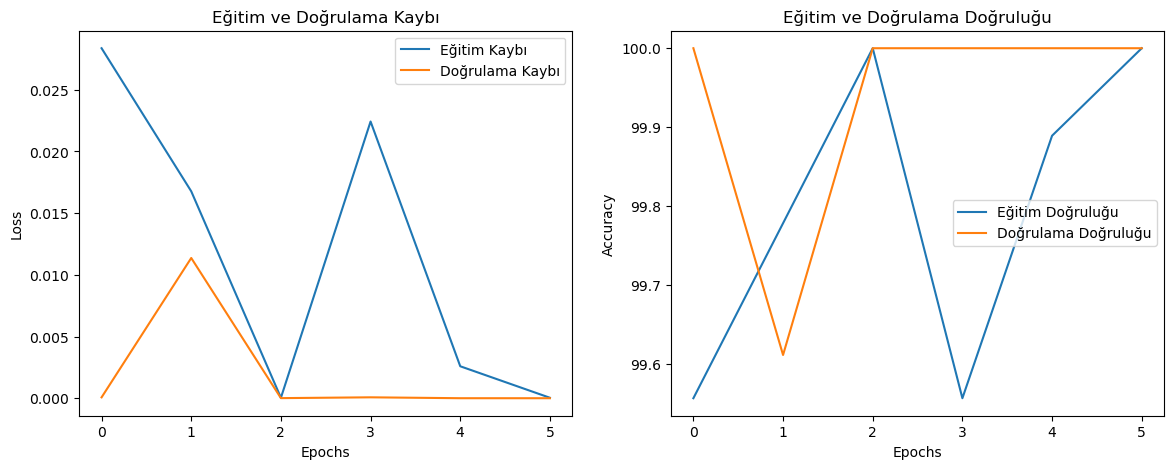

In [14]:
# Eğitim ve doğrulama kayıpları ve doğrulukları
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Eğitim kaybı ve doğruluğu
ax1.plot(train_losses, label='Eğitim Kaybı')
ax1.plot(val_losses, label='Doğrulama Kaybı')
ax1.set_title('Eğitim ve Doğrulama Kaybı')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(train_accuracies, label='Eğitim Doğruluğu')
ax2.plot(val_accuracies, label='Doğrulama Doğruluğu')
ax2.set_title('Eğitim ve Doğrulama Doğruluğu')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()


In [18]:
destination_folder = "/Users/ranakaya/GoruntuIslemeGuncel/SavedModel"
torch.save(model.state_dict(), f"{destination_folder}/Mine.pth")

In [15]:
# Test
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images)
        predicted = torch.round(outputs)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

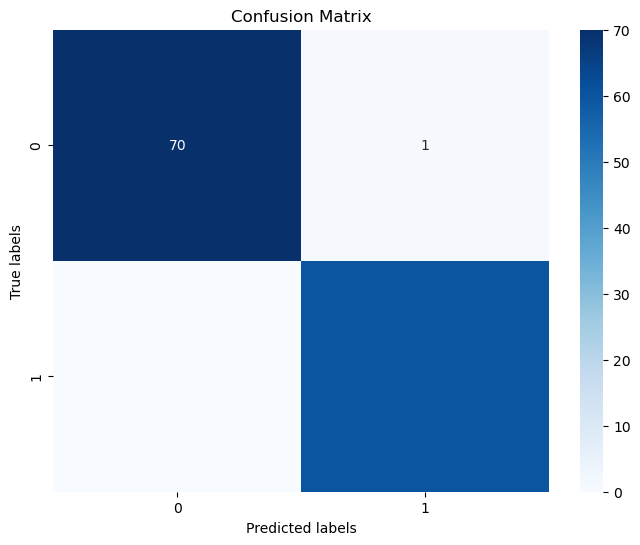

<function confusion_matrix at 0x175b64a60>


In [16]:
# Confusion matrix ve görselleştirme
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
print(confusion_matrix)

In [17]:
print(conf_matrix)

[[70  1]
 [ 0 60]]
